In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.applications import (InceptionResNetV2, NASNetMobile, NASNetLarge, ResNet50, EfficientNetB0)

# Dataset paths
first_set_path = r'Dataset/First Set'
second_set_path = r'Dataset/Second Set'

# Image categories
categories = ['Normal', 'OSCC']

# Function to load images and labels
def load_images_from_folder(folder_path, img_size=(224, 224)):
    images = []
    labels = []
    for category in categories:
        path = os.path.join(folder_path, category)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            images.append(img_array)
            labels.append(0 if category == 'Normal' else 1)
    return np.array(images), np.array(labels)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.1,
    horizontal_flip=True
)

# Load and combine datasets
x_100x, y_100x = load_images_from_folder(first_set_path)
x_400x, y_400x = load_images_from_folder(second_set_path)
x_data = np.concatenate((x_100x, x_400x), axis=0)
y_data = np.concatenate((y_100x, y_400x), axis=0)

# Shuffle and split the dataset
x_data, y_data = shuffle(x_data, y_data, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
train_datagen = datagen.flow(x_train, y_train, batch_size=16)

# Function to build a model using a pre-trained base
def build_model(base_model, img_size=(224, 224), dropout_rate=0.5):
    base_model.trainable = False
    inputs = tf.keras.Input(shape=(*img_size, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model



In [2]:
# InceptionResNetV2
print("\nTraining with InceptionResNetV2...\n")
inception_resnet_model = build_model(InceptionResNetV2(weights='imagenet', include_top=False))
inception_resnet_history = inception_resnet_model.fit(train_datagen, validation_data=(x_test, y_test), epochs=15)


Training with InceptionResNetV2...


Epoch 1/15


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 39s 490ms/step - accuracy: 0.6897 - loss: 0.6503 - val_accuracy: 0.7755 - val_loss: 0.5021
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 425ms/step - accuracy: 0.7678 - loss: 0.6063 - val_accuracy: 0.7755 - val_loss: 0.4744
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 428ms/step - accuracy: 0.7352 - loss: 0.5514 - val_accuracy: 0.7878 - val_loss: 0.4727
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 424ms/step - accuracy: 0.7363 - loss: 0.5512 - val_accuracy: 0.8000 - val_loss: 0.4537
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 26s 426ms/step - accuracy: 0.7525 - loss: 0.5235 - val_accuracy: 0.8000 - val_loss: 0.4421
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 428ms/step - accuracy: 0.7914 - loss: 0.4690 - val_accuracy: 0.8000 - val_loss: 0.4317
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 432ms/step - accuracy: 0.7932 - loss: 0.4895 - val_accuracy: 0.8082 - val_loss: 0.4332
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 438ms/step - accuracy: 0.7551 - loss: 0.5169 - val_accuracy: 0.812

8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step 


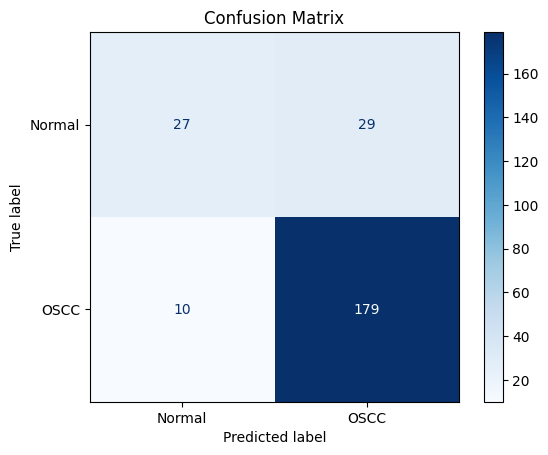

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Get model predictions
y_pred_prob = inception_resnet_model.predict(x_test)  # Probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert to binary predictions

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "OSCC"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [4]:
# NASNetMobile
print("\nTraining with NASNetMobile...\n")

# Ensure the input size is set to 224x224
nasnet_mobile_model = build_model(NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
nasnet_mobile_history = nasnet_mobile_model.fit(train_datagen, validation_data=(x_test, y_test), epochs=15)


Training with NASNetMobile...

Epoch 1/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 260ms/step - accuracy: 0.6991 - loss: 0.6421 - val_accuracy: 0.7918 - val_loss: 0.5289
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 185ms/step - accuracy: 0.7386 - loss: 0.5663 - val_accuracy: 0.7878 - val_loss: 0.5124
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 189ms/step - accuracy: 0.7319 - loss: 0.5460 - val_accuracy: 0.7837 - val_loss: 0.4986
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 188ms/step - accuracy: 0.7403 - loss: 0.5379 - val_accuracy: 0.7959 - val_loss: 0.4919
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 199ms/step - accuracy: 0.7712 - loss: 0.4986 - val_accuracy: 0.7918 - val_loss: 0.4887
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 185ms/step - accuracy: 0.7720 - loss: 0.4859 - val_accuracy: 0.8082 - val_loss: 0.4758
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - accuracy: 0.7651 - loss: 0.5063 - val_accuracy: 0.8041 - val_loss: 0.4737
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms/step - accuracy: 

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 668ms/step


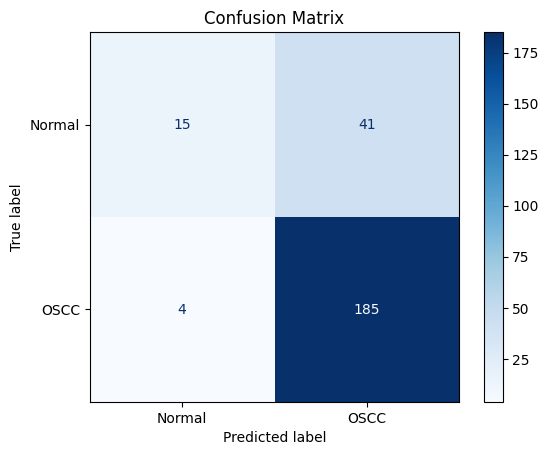

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Get model predictions
y_pred_prob = nasnet_mobile_model.predict(x_test)  # Probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert to binary predictions

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "OSCC"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [6]:
# NASNetLarge
print("\nTraining with NASNetLarge...\n")
nasnet_large_model = build_model(NASNetLarge(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
nasnet_large_history = nasnet_large_model.fit(train_datagen, validation_data=(x_test, y_test), epochs=15)


Training with NASNetLarge...

Epoch 1/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.7134 - loss: 0.6001 - val_accuracy: 0.7633 - val_loss: 0.5083
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.7808 - loss: 0.4852 - val_accuracy: 0.8122 - val_loss: 0.4702
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.8086 - loss: 0.4368 - val_accuracy: 0.7878 - val_loss: 0.4823
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.7881 - loss: 0.4674 - val_accuracy: 0.8122 - val_loss: 0.4430
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8039 - loss: 0.4060 - val_accuracy: 0.8041 - val_loss: 0.4299
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8099 - loss: 0.4189 - val_accuracy: 0.8286 - val_loss: 0.4182
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.7974 - loss: 0.4278 - val_accuracy: 0.8286 - val_loss: 0.4166
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.8386 - loss: 0.4062 - 

8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step


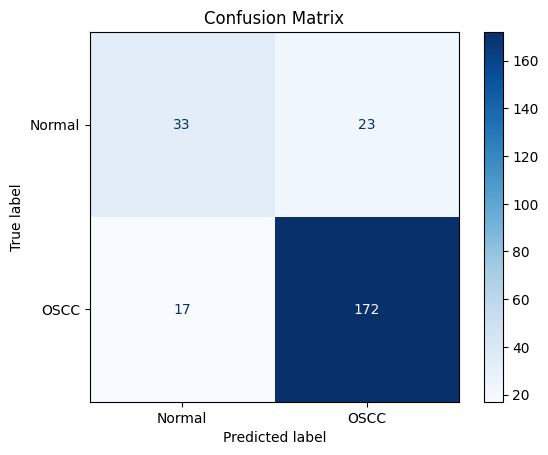

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Get model predictions
y_pred_prob = nasnet_large_model.predict(x_test)  # Probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert to binary predictions

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "OSCC"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [8]:
def build_model_50(base_model, img_size=(224, 224), dropout_rate=0.5):
    base_model.trainable = False
    inputs = tf.keras.Input(shape=(*img_size, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [9]:
# ResNet50
print("\nTraining with ResNet50...\n")
resnet50_model = build_model_50(ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
resnet50_history = resnet50_model.fit(train_datagen, validation_data=(x_test, y_test), epochs=15)


Training with ResNet50...

Epoch 1/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 393ms/step - accuracy: 0.6712 - loss: 0.6544 - val_accuracy: 0.7714 - val_loss: 0.5422
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 23s 370ms/step - accuracy: 0.7859 - loss: 0.5433 - val_accuracy: 0.7714 - val_loss: 0.5486
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 23s 371ms/step - accuracy: 0.7539 - loss: 0.5707 - val_accuracy: 0.7714 - val_loss: 0.5367
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 23s 372ms/step - accuracy: 0.7509 - loss: 0.5712 - val_accuracy: 0.7714 - val_loss: 0.5439
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 23s 368ms/step - accuracy: 0.7555 - loss: 0.5740 - val_accuracy: 0.7714 - val_loss: 0.5466
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 22s 358ms/step - accuracy: 0.7548 - loss: 0.5594 - val_accuracy: 0.7714 - val_loss: 0.5513
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 22s 347ms/step - accuracy: 0.7573 - loss: 0.5629 - val_accuracy: 0.7714 - val_loss: 0.5479
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 343ms/step - accuracy: 0.75

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 682ms/step


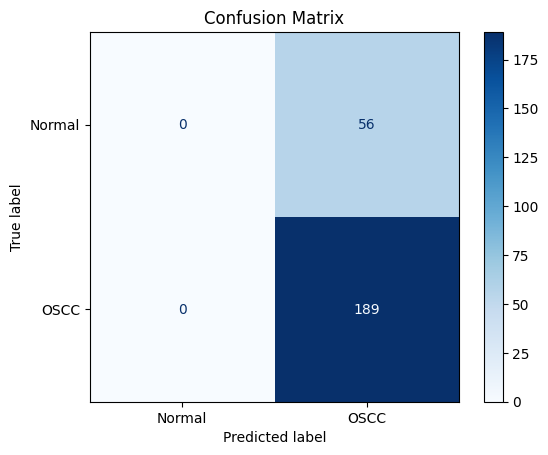

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Get model predictions
y_pred_prob = resnet50_model.predict(x_test)  # Probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert to binary predictions

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "OSCC"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [11]:
def build_model_effi(base_model, img_size=(224, 224), dropout_rate=0.5):
    base_model.trainable = False
    inputs = tf.keras.Input(shape=(*img_size, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [12]:
# EfficientNetB0
print("\nTraining with EfficientNetB0...\n")
efficientnet_model = build_model_effi(EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
efficientnet_history = efficientnet_model.fit(train_datagen, validation_data=(x_test, y_test), epochs=15)


Training with EfficientNetB0...

Epoch 1/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 18s 220ms/step - accuracy: 0.7071 - loss: 0.5903 - val_accuracy: 0.7714 - val_loss: 0.5407
Epoch 2/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 198ms/step - accuracy: 0.7744 - loss: 0.5471 - val_accuracy: 0.7714 - val_loss: 0.5396
Epoch 3/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 15s 238ms/step - accuracy: 0.7494 - loss: 0.5732 - val_accuracy: 0.7714 - val_loss: 0.5424
Epoch 4/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 14s 229ms/step - accuracy: 0.7564 - loss: 0.5733 - val_accuracy: 0.7714 - val_loss: 0.5380
Epoch 5/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - accuracy: 0.7617 - loss: 0.5533 - val_accuracy: 0.7714 - val_loss: 0.5495
Epoch 6/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 215ms/step - accuracy: 0.7584 - loss: 0.5551 - val_accuracy: 0.7714 - val_loss: 0.5379
Epoch 7/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 215ms/step - accuracy: 0.7696 - loss: 0.5391 - val_accuracy: 0.7714 - val_loss: 0.5375
Epoch 8/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 217ms/step - accuracy

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 584ms/step


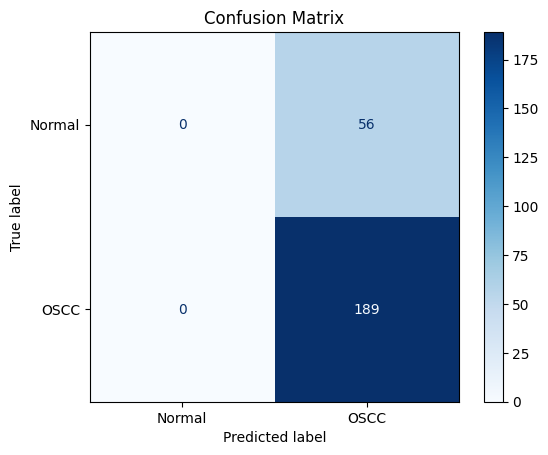

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Get model predictions
y_pred_prob = efficientnet_model.predict(x_test)  # Probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert to binary predictions

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "OSCC"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()